In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import imutils

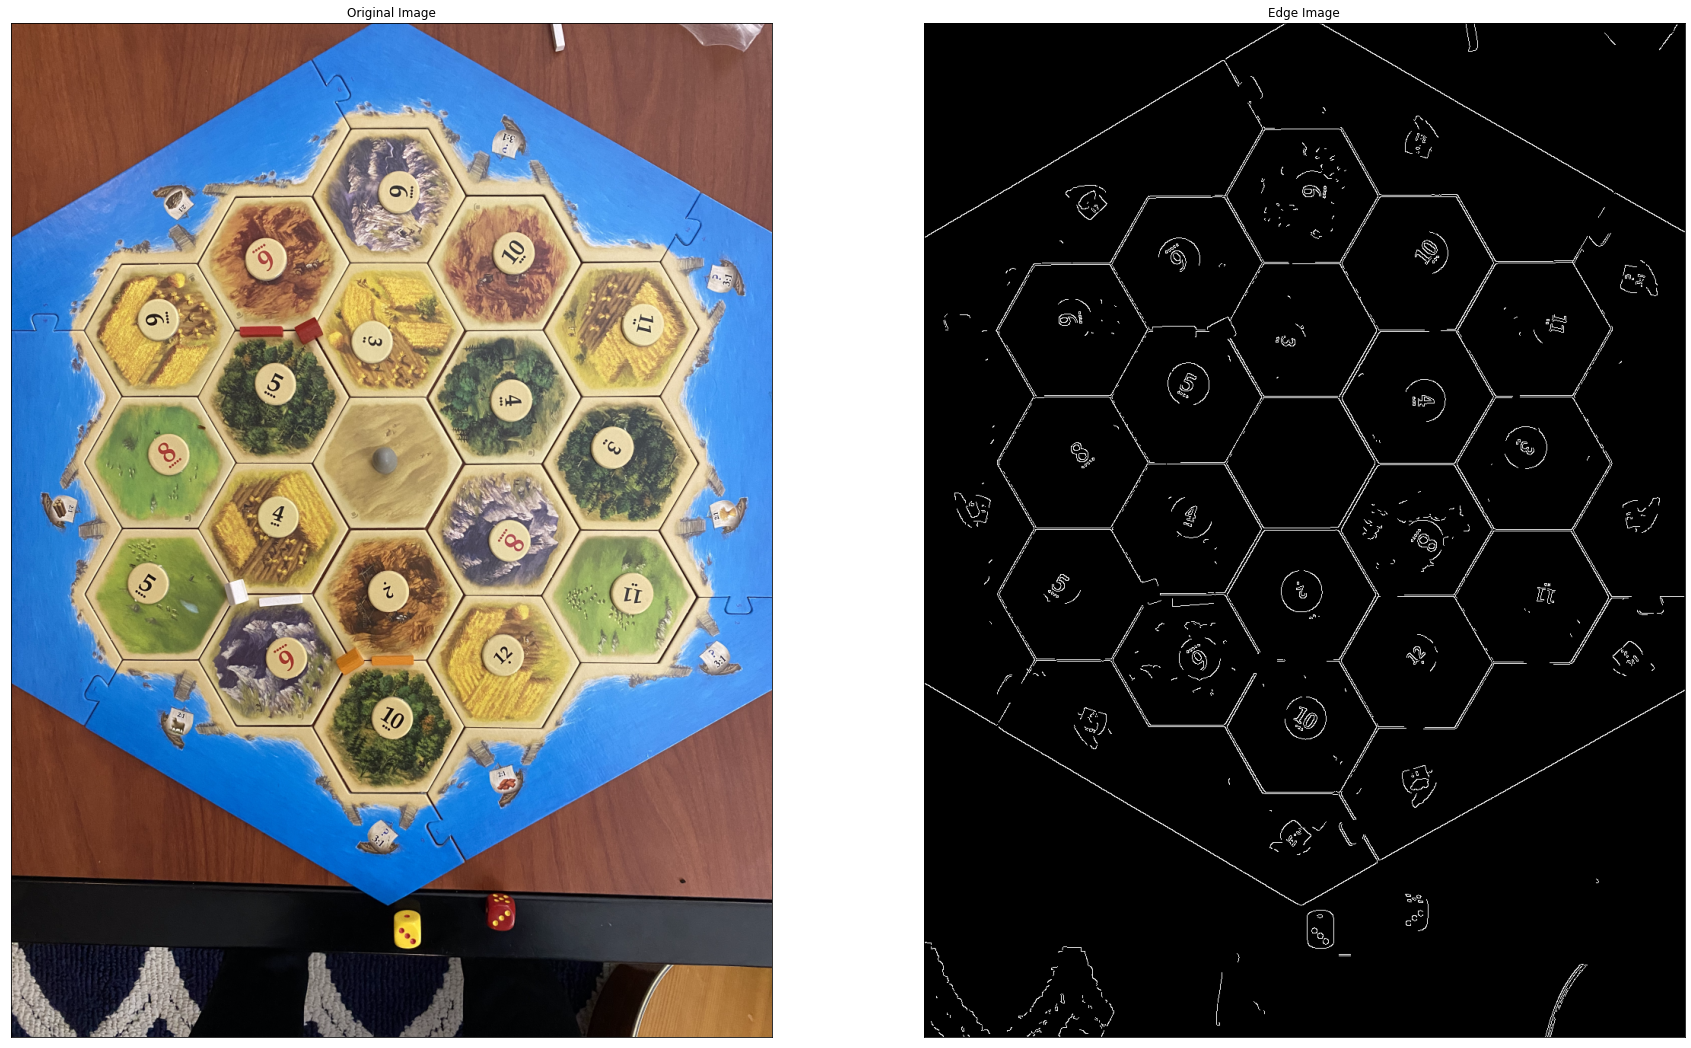

In [2]:
############################################
# Read image and get canny edge detection
############################################

# read img
img = cv.imread('photos/IMG_7864.png')[:,:,::-1]
img = imutils.resize(img, width=1000)

# get canny
edges = cv.Canny(img,500,700)

# see img
plt.figure(figsize=(30, 30))
plt.subplot(121),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

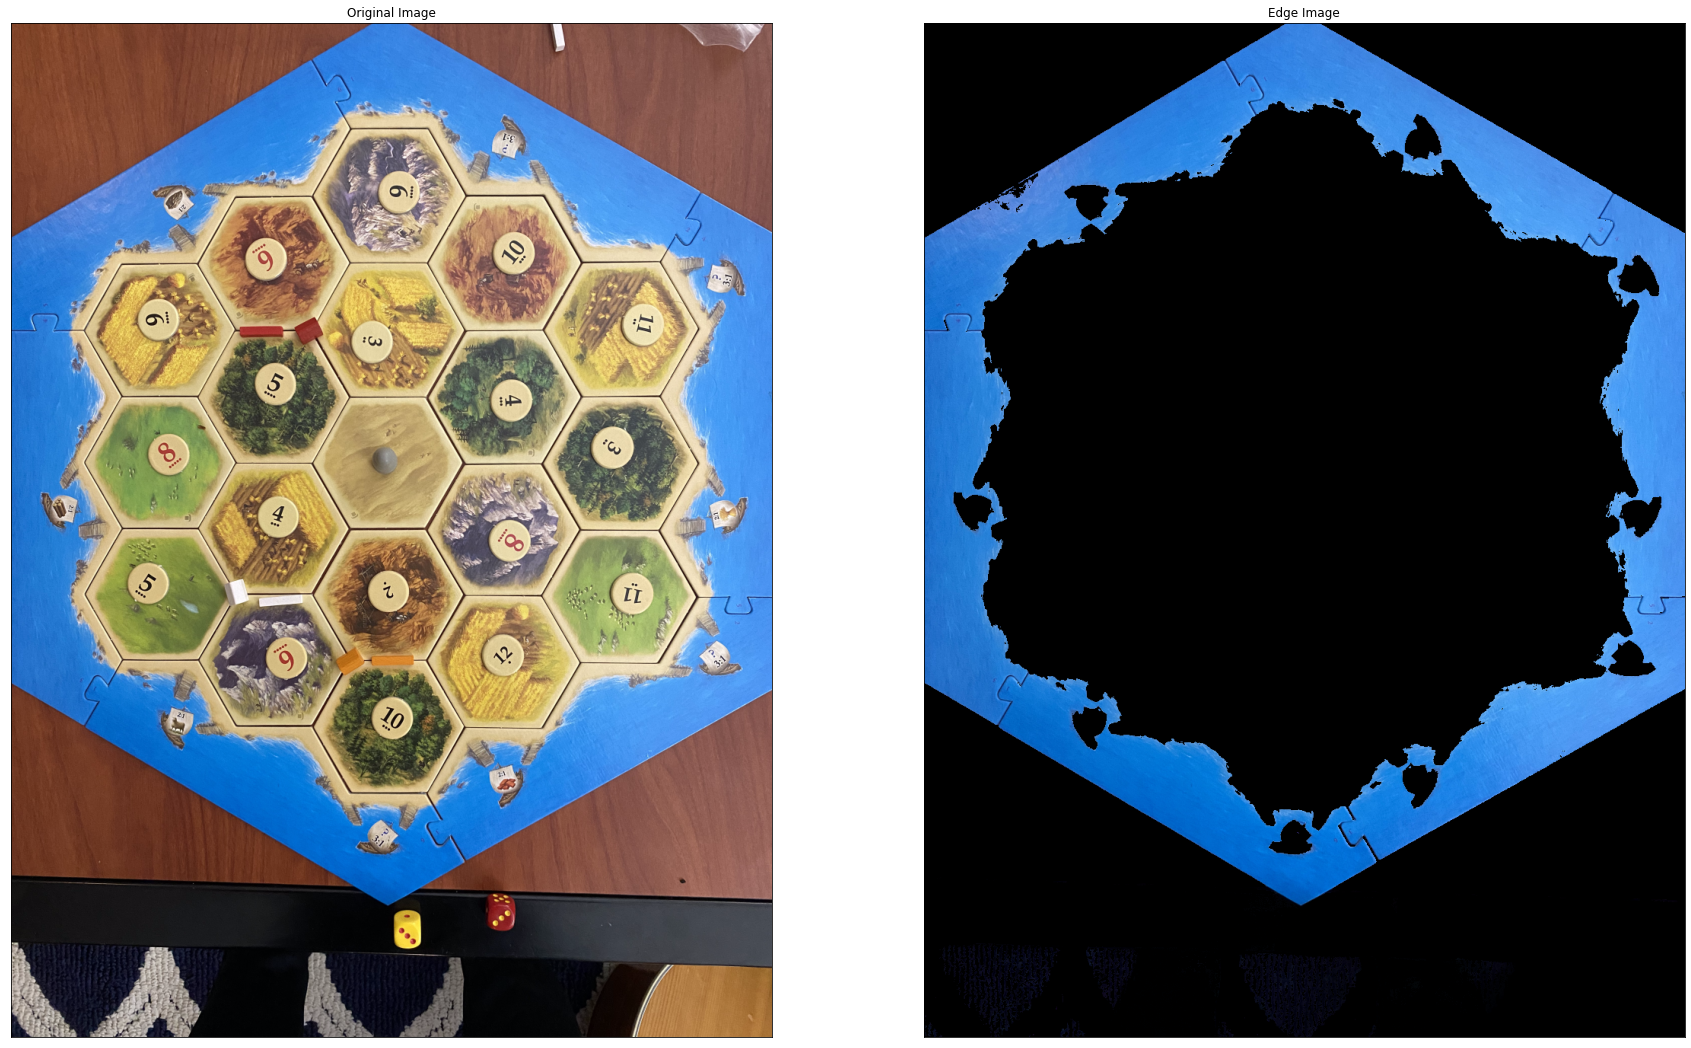

In [3]:
################
# Get blue mask
################

# create boundaries
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
blue_lower=np.array([80,140,0],np.uint8)
blue_upper=np.array([140,255,255],np.uint8)

# find mask
blue_mask = cv.inRange(hsv, blue_lower, blue_upper)

# see img
res = cv.bitwise_and(img,img, mask= blue_mask)
plt.figure(figsize=(30, 30))
plt.subplot(121),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(res)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

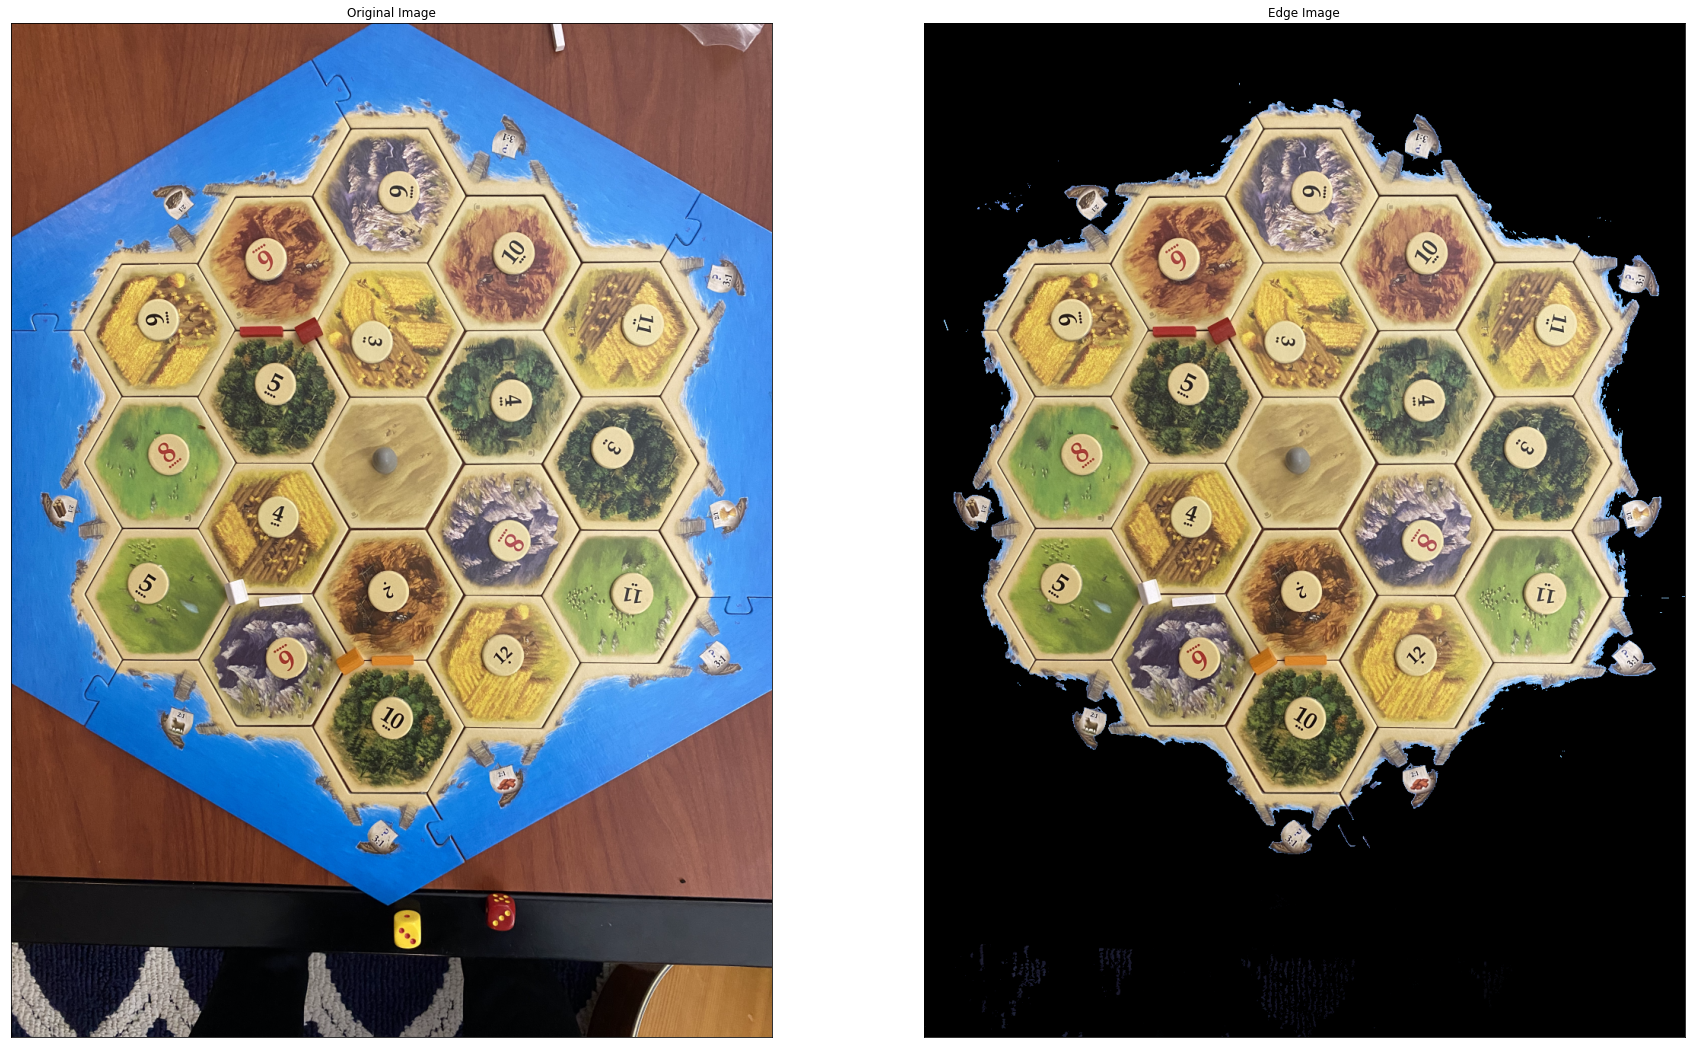

In [22]:
############################
# Expand blue mask outwards
############################

# create masks
blue_mask_binary = img.copy()
h, w = img.shape[:2]
flood_mask = np.zeros((h+2, w+2), np.uint8)

# flood fill the 4 corners
cv.floodFill(blue_mask, flood_mask, (0,0), 255)
cv.floodFill(blue_mask, flood_mask, (w-1,0), 255)
cv.floodFill(blue_mask, flood_mask, (0,h-1), 255)
cv.floodFill(blue_mask, flood_mask, (w-1,h-1), 255)

# see img
blue_mask_inv = cv.bitwise_not(blue_mask)
cropped_img = cv.bitwise_and(img,img, mask=blue_mask_inv)
plt.figure(figsize=(30, 30))
plt.subplot(121),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cropped_img)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

582
502


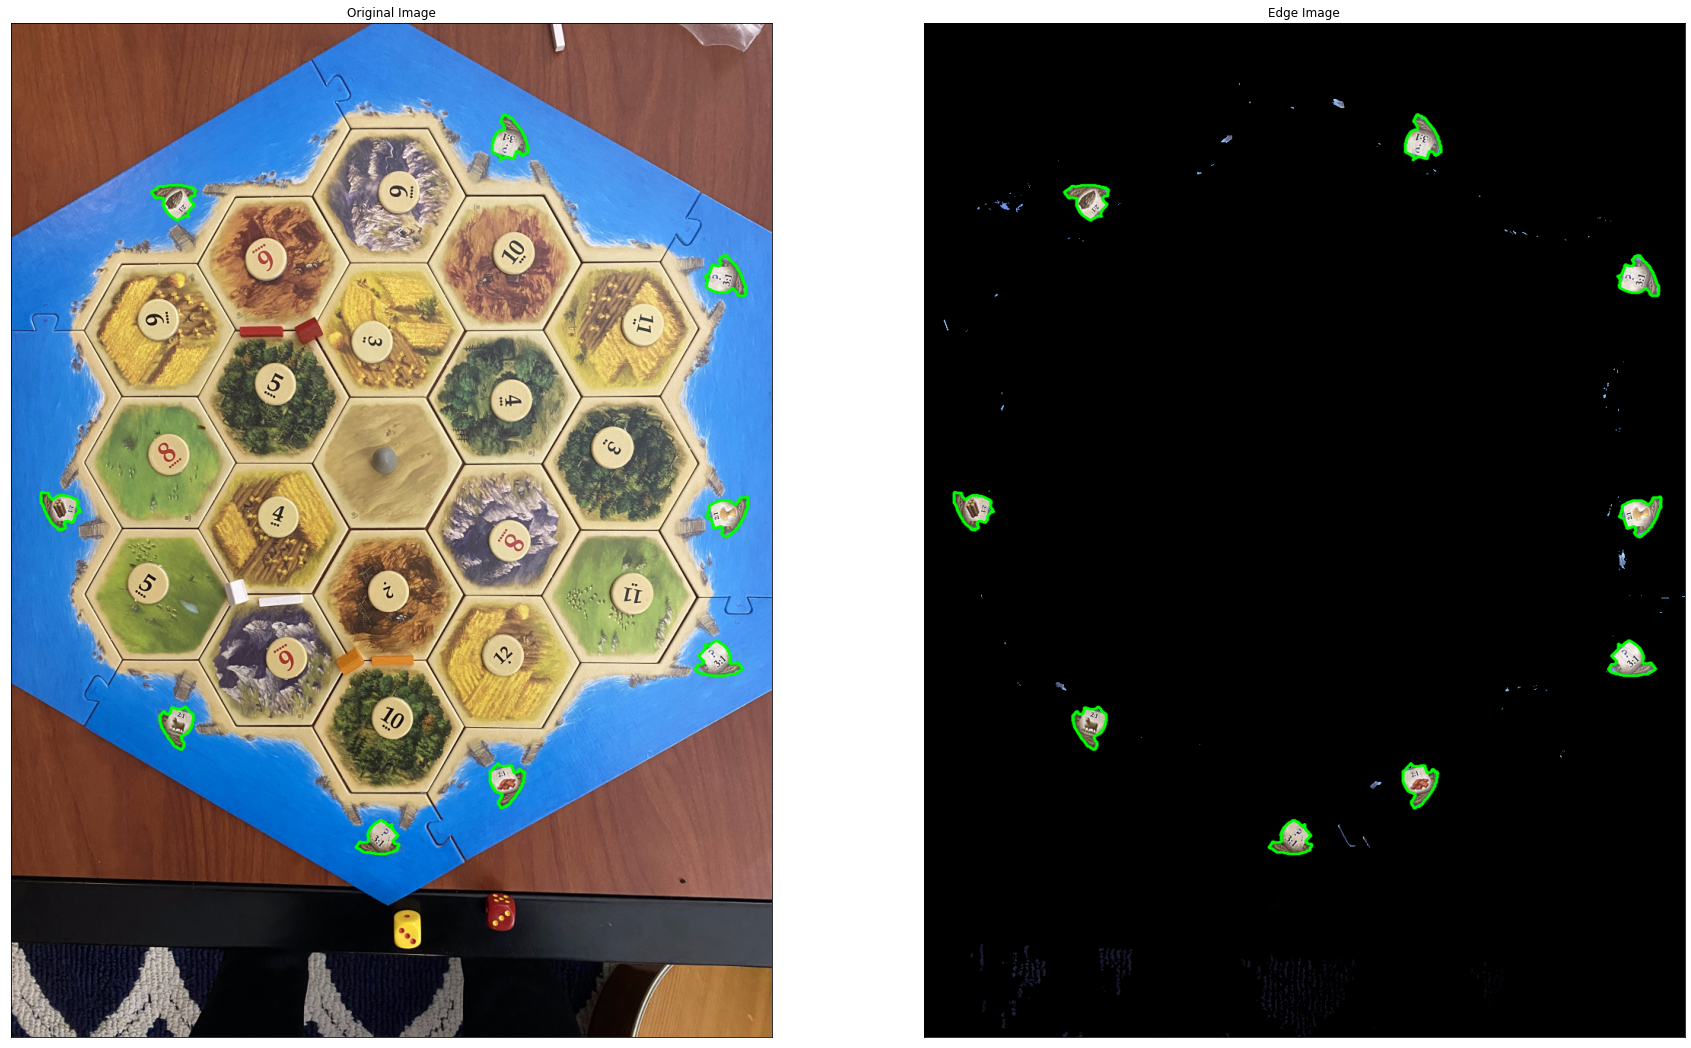

In [37]:
####################
# Get ship contours
####################

# get center of mass
mass_x, mass_y = np.where(blue_mask <= 0)
cent_x = int(np.average(mass_x))
cent_y = int(np.average(mass_y))
print(cent_x)
print(cent_y)

# get ship mask
ship_flood_mask = np.zeros((h+2, w+2), np.uint8)
ship_mask = blue_mask.copy()
cv.floodFill(ship_mask, ship_flood_mask, (cent_x,cent_y), 255)
ship_mask_inv = cv.bitwise_not(ship_mask)

# find contours
contours, hierarchy = cv.findContours(image=ship_mask_inv, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_NONE)

# sort contours in decreasing order and take first 9
contours = sorted(contours, key=lambda x:cv.contourArea(x), reverse=True)
contours = contours[0:9]

# draw contours on the original image
image_copy = img.copy()
cv.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)
ship_img = cv.bitwise_and(img,img, mask=ship_mask_inv)
cv.drawContours(image=ship_img, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv.LINE_AA)

# see ship img
plt.figure(figsize=(30, 30))
plt.subplot(121),plt.imshow(image_copy)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(ship_img)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()


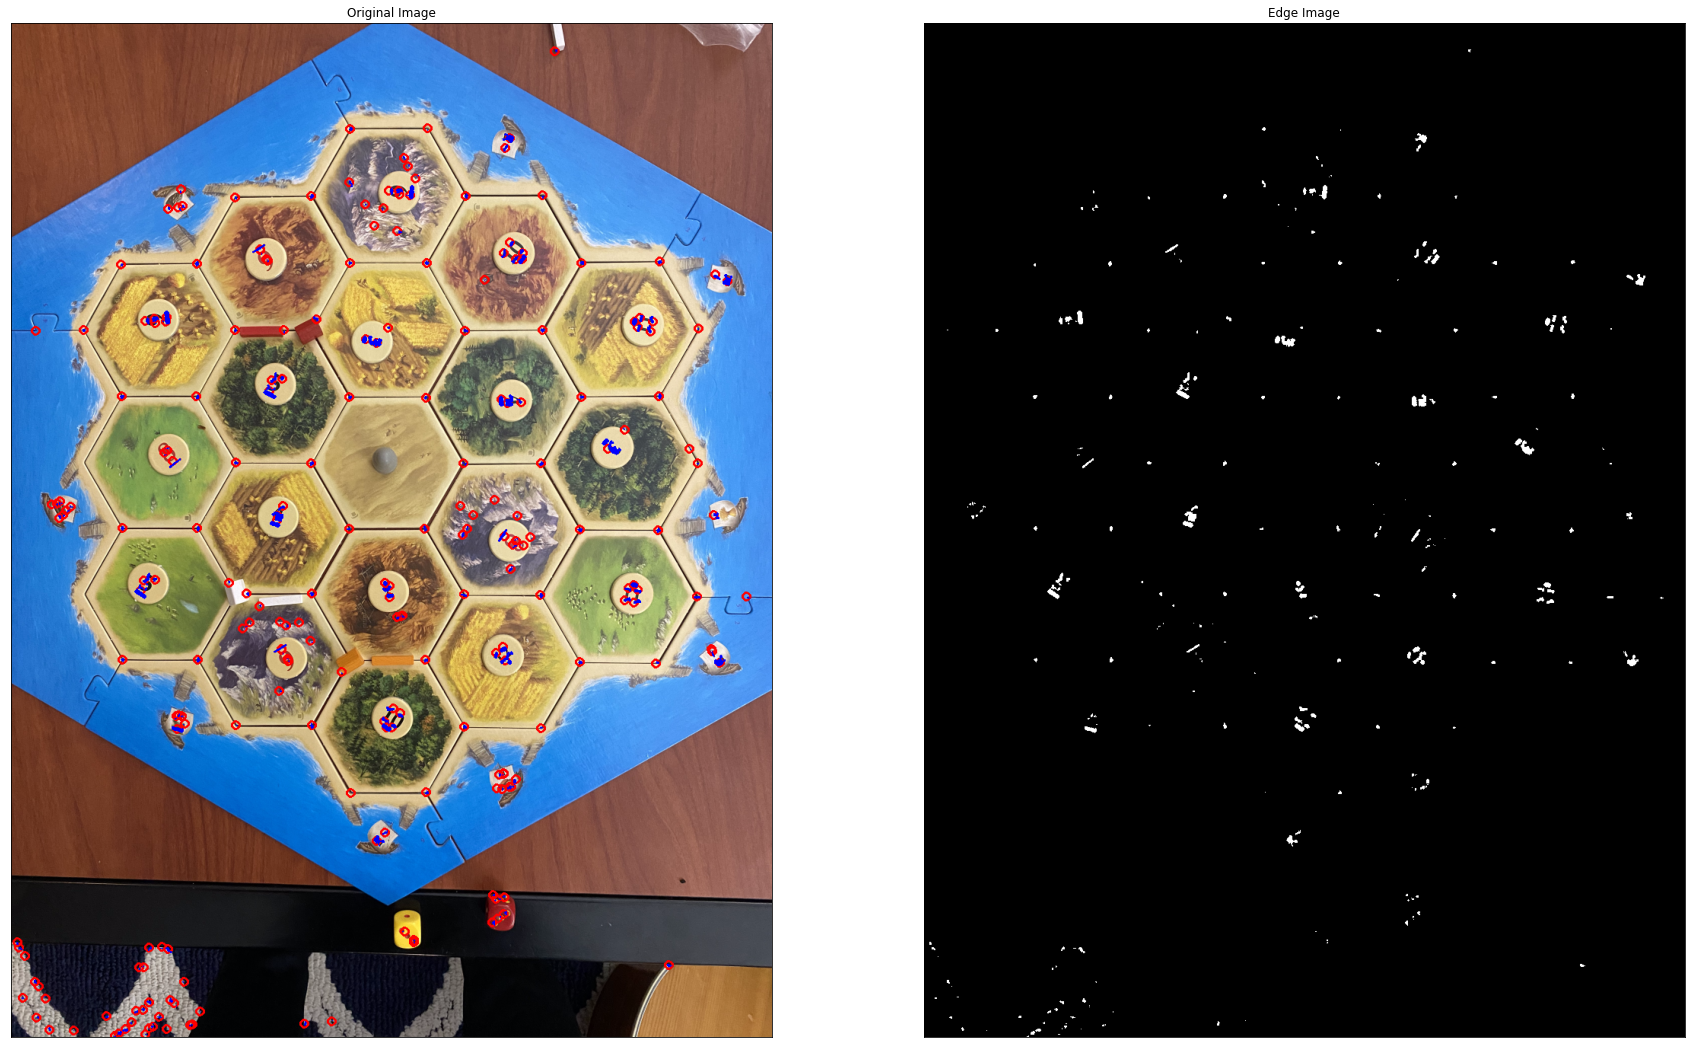

In [23]:
####################
# Get corner points
####################

# get corners
corner_img = img.copy()
gray = cv.cvtColor(corner_img, cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv.cornerHarris(gray,5,3,0.04)
ret, dst = cv.threshold(dst,0.1*dst.max(),255,0)
dst = np.uint8(dst)
ret, labels, stats, centroids = cv.connectedComponentsWithStats(dst)
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.1)
corners = cv.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
for i in range(1, len(corners)):
    # print(corners[i])
    corner_img = cv.circle(corner_img, (int(corners[i][0]), int(corners[i][1])), 5, (255, 0, 0), 2)

# apply corner mask
corner_mask = np.zeros(corner_img.shape[:2], dtype="uint8")
corner_img[dst>0.1*dst.max()]=[0,0,255]
corner_mask[dst>0.1*dst.max()]=1

# see img
plt.figure(figsize=(30, 30))
plt.subplot(121),plt.imshow(corner_img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(corner_mask,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
# Get circle intersection points

# Approach 1: 
# - int minDistanceLow = min distance between two circles
# - int minDistanceHigh = minDistanceLow + 'X'
#     - where 'X' is some range value we find through trial and error
# - for each circle find the circles whose distance is between minDistanceLow and minDistanceHig
# - sort these circles in clockwise direction
# - iterate across these circles in pairs, checking if the pair's distance is valid
# - get the average x and y of these circles


# Approach 2: 
# - get corners using corner Harris algorithm
# - find hexagons 
# - extend hexagon grid
